# Eigentechno 8820 Hz

In [1]:
import array, math, time, argparse, sys
import scipy.io.wavfile as wav
import scipy
import numpy as np
import datetime
import matplotlib.pyplot as plt
import os
import json
import h5py

proc_srate = 8820
srate = proc_srate

# string used to identify outputs
iden_str = "8820_full"

In [2]:
# useful functions:

def read_wav_mono(filename, target_srate=44100):
    fs, samps = wav.read(filename)
    #print(samps.shape, len(samps.shape))
    if len(samps.shape) > 1:
        samps = np.apply_along_axis(np.sum, 1, samps) / 2, fs
        
    if target_srate == 22050:
        return np.delete(samps, range(1, samps.shape[0], 2)), 22050
    if target_srate == 14700:
        return np.delete(samps, [i for i in range(samps.shape[0]) if i % 3 != 0]), 14700
    if target_srate == 8820:
        return np.delete(samps, [i for i in range(samps.shape[0]) if i % 5 != 0]), 8820

    return samps, fs

def normalize(arr):
    arr[:] = arr[:] / np.max(np.abs(arr))

scale_coeff = (2**15-1)
def write_wav(arr, fs, fnm, normalized=True):
    wav.write(fnm, fs, np.asarray(scale_coeff *
        arr / (np.max(np.abs(arr)) if normalized else 1.0), dtype=np.int16))
    
def make_dir(dirname):
    dirs = dirname.split("/")
    newdir = dirs[-1]
    if newdir in os.listdir("./" + "/".join(dirs[:-1])):
        print("existing dir", dirname)
        return
    print("creating", dirname)
    os.mkdir("./" + dirname)

In [150]:
# proc_srate = 8820
h5f = h5py.File("../dataset/loops_" + str(proc_srate) + "hz.h5",'r')
XX = h5f['loops'][:]
mean_wave = h5f['mean'][:]
h5f.close()
N = XX.shape[0]
slen = XX.shape[1]

In [151]:
def loop(n, X):
    return np.concatenate([X for i in range(n)], axis=0)

folder = "output/" + iden_str
make_dir(folder)
write_wav(mean_wave, srate, folder + "/" + iden_str + "_mean.wav")
write_wav(loop(4,mean_wave), srate, folder + "/" + iden_str + "_mean_looped.wav")
write_wav(loop(4,mean_wave), srate, folder + "/" + iden_str + "_mean__not_normalized_looped.wav", normalized=False)
write_wav(mean_wave, srate, folder + "/" + iden_str + "_mean__not_normalized.wav", normalized=False)

existing dir output/8820_full


In [157]:
folder = "output/" + iden_str + "/original"
make_dir(folder)

savelist = [175, 1060, 1360, 1420, 2650, 2930, 60947, 60980]

for i in savelist:
    write_wav(XX[i,:] + mean_wave, srate, folder + "/" + str(i) + ".wav")

existing dir output/8820_full/original


## Applying PCA

In [8]:
U, s, Vt = scipy.linalg.svd(XX, full_matrices=False)

In [9]:
del XX

In [10]:
W = U.dot(np.diag(s))

In [11]:
def save_svd_output(fnm, W, s, Vt, folder="saved_params"):
    make_dir(folder)
    h5f = h5py.File(folder + "/" + fnm + ".h5", "w")
    h5f.create_dataset('W', data=W)
    h5f.create_dataset('s', data=s)
    h5f.create_dataset('Vt', data=Vt)
    h5f.close()
    
save_svd_output(iden_str + "svd_out", W, s, Vt)

existing dir saved_params


In [207]:
# save some eigenvectors
folder = "output/" + iden_str + "/eigenvectors"
make_dir(folder)
for i in range(400):
    write_wav(Vt[i,:], srate, folder + "/" + str(i) + ".wav")

existing dir output/8820_full/eigenvectors


## Analyzing the Eigenvectors

In [189]:
norm = np.vectorize(lambda z: np.sqrt(z.real*z.real + z.imag*z.imag))

def fft_avg(X, win_size=2048):
    fftscale = 1 #1 / win_size
    slen = X.shape[0]
    avg = np.zeros(win_size)
    count = 1
    for start in range(0, slen - win_size + 1, win_size//4):
        normfft = norm(scipy.fft(X[start:start+win_size])) * fftscale
        avg = avg + normfft #* normfft
        count += 1
    count -= 1
    avg = avg / count       
    #print(np.max(avg))
    return avg

def spectrum_plot(spectrum, srate, show=True, title="", averaging=0, alpha=0.8):
    slen = spectrum.shape[0]
    S = 20 * np.log10(spectrum[:slen//2])
    newS = np.zeros(S.shape)
    if averaging > 0:
        for i in range(1,S.shape[0]):
            width = round((np.log10(i * srate / slen))**averaging)
            width = 0 if width < 0 else int(width)
            left_end = 0 if i - width < 0 else i - width
            right_end = slen if i + width + 1 > slen else i + width + 1
            newS[i] = np.mean(S[left_end : right_end])
    else:
        newS = S
    plt.plot(np.linspace(0,srate/2,slen//2), newS, alpha=alpha)
    plt.xscale('log')
    #plt.title(title)
    
    if show:
        plt.show()

existing dir output/8820_full/eigenvectorFFT


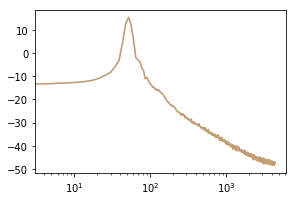

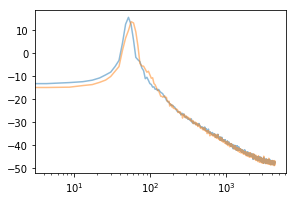

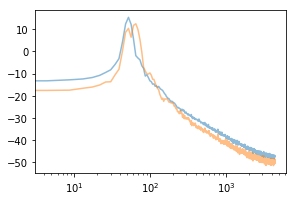

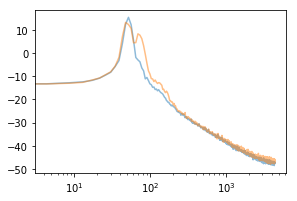

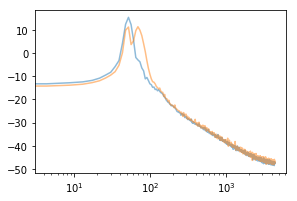

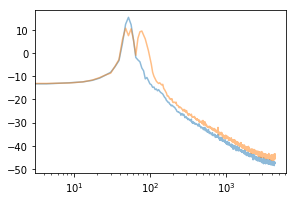

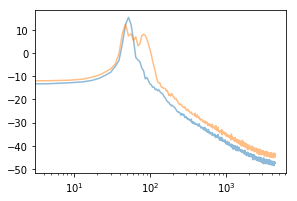

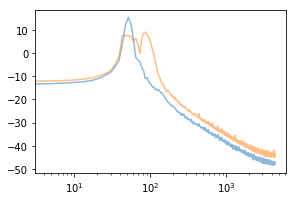

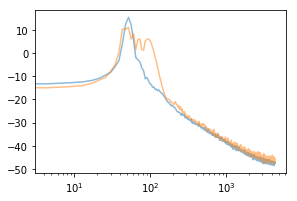

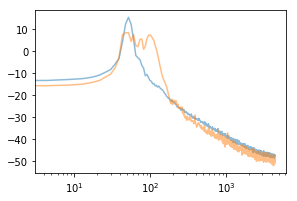

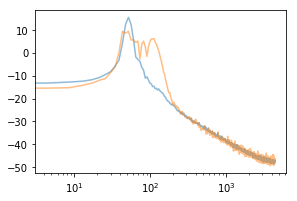

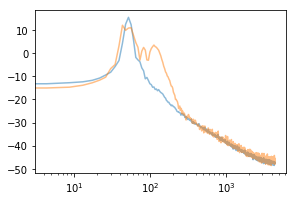

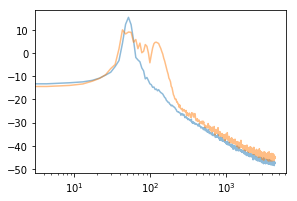

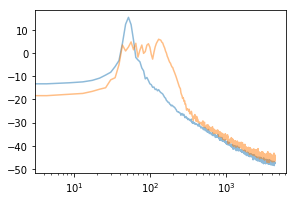

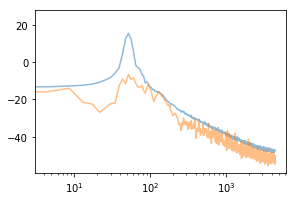

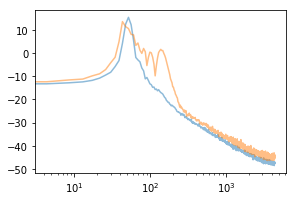

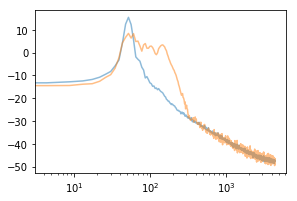

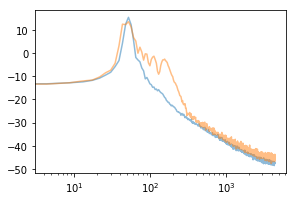

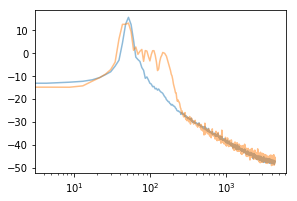

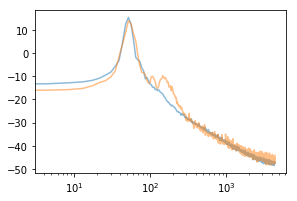

In [190]:
nn = 20
folder = "output/" + iden_str + "/eigenvectorFFT"
make_dir(folder)

for i in range(nn):
    plt.figure(figsize=(4.5,3))
    spectrum_plot(fft_avg(Vt[0]), proc_srate, show=False, title=str(i), averaging=0, alpha=0.5)
    spectrum_plot(fft_avg(Vt[i]), proc_srate, show=False, title=str(i), averaging=0, alpha=0.5)
    plt.savefig(folder + "/" + str(i), dpi=200, transparent=True)
    plt.show() 
    

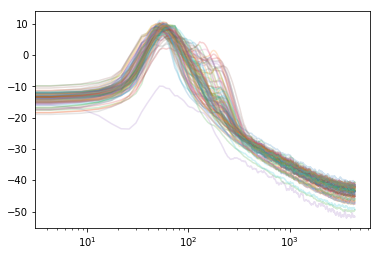

In [191]:
nn = 100
for i in range(nn):
    spectrum_plot(fft_avg(Vt[i]), proc_srate, show=False, title=str(i), averaging=2, alpha=0.2)
plt.savefig("output/" + iden_str + "/" + "first100eigens", dpi=300, transparent=True)
plt.show() 

## Singular values

In [173]:
h5f = h5py.File("saved_params/8820_fullsvd_out.h5",'r')
s = h5f["s"][:]
h5f.close()

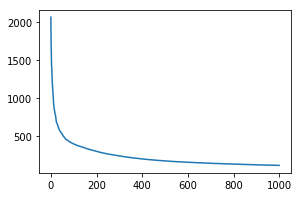

In [177]:
nn = 1000
plt.figure(figsize=(4.5,3))
plt.plot(range(nn),s[:nn])
plt.savefig("output/" + iden_str + "/singular_values", dpi=200, transparent=True)
plt.show()

# Approximations

In [48]:
# We computed the coefficients above by
# W = U.dot(np.diag(s))

In [60]:
# songs to be apprximated
savelist

[175, 1060, 1360, 1420, 2650, 2930, 60947, 60980]

In [131]:
numlist = [1, 33, 82, 330, 826, 3307, 8269, 16537] # out of 16538 eigenvectors
approxes = [W[savelist,:k].dot(Vt[:k,:]) for k in numlist] 

In [132]:
dir_name = "output/" + iden_str + "/approxes"
make_dir(dir_name)
for in_sav, i in enumerate(savelist):
    for in_num, num_eigens in enumerate(numlist):
        write_wav(approxes[in_num][in_sav], srate, dir_name + "/" + str(i) + "_" + str(num_eigens) + ".wav")

existing dir output/8820_full/approxes


Let's add the mean back too:

In [133]:
approxes_with_mean = approxes + mean_wave

In [134]:
dir_name = "output/" + iden_str + "/approxes"
make_dir(dir_name)
for in_sav, i in enumerate(savelist):
    for in_num, num_eigens in enumerate(numlist):
        write_wav(approxes_with_mean[in_num][in_sav], srate, dir_name + "/withmean_" + str(i) + "_" + str(num_eigens) + ".wav")

existing dir output/8820_full/approxes


## Transition from 1 to all eigenvectors being used to approximate

In [166]:
def awesome_loop(n):
    print("starting loop:", n)
    X = XX[n]

    num_loops = 32
    num_approxes = Vt.shape[0]
    approxes_per_loop = 4
    start_locs = [i * (slen // approxes_per_loop) for i in range(approxes_per_loop)] + [slen]
    approx_select = lambda a: int(round(a*a*1.1333))
    fin_loop = np.zeros(num_loops * slen, dtype=np.float16)
    Xd = X + mean_wave
    
    # counting over approx no
    for count in range(num_loops * approxes_per_loop):
        if count % approxes_per_loop == 0:
            print(count // approxes_per_loop, end=" ")
        k = approx_select(count)
        if k < num_approxes:
            approx = W[n,:k].dot(Vt[:k,:]) + mean_wave
        else:
            #k = num_approxes - 1
            #approx = W[n,:k].dot(Vt[:k,:]) + mean_wave
            approx = Xd
        T = approx
        start = start_locs[count % approxes_per_loop]
        end = start_locs[(count % approxes_per_loop) + 1]
        fin_loop[ slen * (count // approxes_per_loop) + start : slen * (count // approxes_per_loop) + end ] = T[start:end]

    #fin_loop = np.concatenate([fin_loop, loop(8, Xd)], axis=0)
    return fin_loop

#savelist2 = [1420]
dir_name = "output/" + iden_str + "/approxes"
make_dir(dir_name)
for sav in savelist:
    X = awesome_loop(sav)
    write_wav(X, srate, dir_name + "/" + str(sav) + "_twm.wav")


existing dir output/8820_full/approxes
starting loop: 175
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 1060
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 1360
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 1420
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 2650
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 2930
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 60947
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 starting loop: 60980
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

## Analyzing the average frequency spectrum

In [ ]:
win_size = 2048
avg_fft = np.zeros(win_size, dtype=np.float64)
num_ffts = 1000
for i in range(num_ffts):
    if i % 10 == 0:
        print(i, end=" ")
    new_fft = fft_avg(XX[np.random.randint(1,N)], win_size=win_size)
    #print(np.max(new_fft))
    avg_fft = avg_fft + new_fft

avg_fft = avg_fft / num_ffts

In [183]:
big_avg_fft = avg_fft

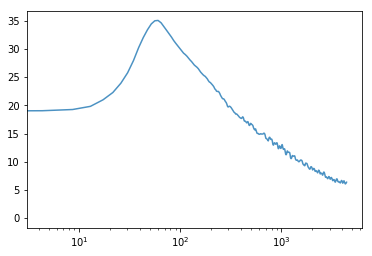

In [241]:
# nn = 1000
# for i in range(nn):
#     spectrum_plot(fft_avg(Vt[i]), proc_srate, show=False, title=str(i), averaging=0, alpha=0.2)
#plt.savefig("output/" + iden_str + "/" + "first100eigens", dpi=300, transparent=True)
#plt.show() 
spectrum_plot(avg_fft, proc_srate, averaging=2, show=False)
plt.savefig("output/" + iden_str + "/" + "average_fft", dpi=300, transparent=True)
plt.show()

## Finding a good frequency scale for equalization:

In [ ]:
# as usual, ith bin has the amplitude of freq i * srate/slen
def freq_scale2(i, srate=proc_srate, slen=slen):
    if i > slen // 2:
        return freq_scale2(slen - 1 - i, srate=proc_srate, slen=slen)
    freq = i * srate / slen
    low_start = 50
    high_end = 0.5 * srate / 2 
    slope = 0.454 
    c = 0.12
    a = 0
    b = np.log10(high_end/50)
    g = lambda x: 1 - slope * x + c*(x - a)*(x - b)
    if freq < low_start:
        toret = 1.0
    elif freq < high_end:
        toret = g(np.log10(freq / 50))
    else:
        toret = g(np.log10(high_end / 50))
    return  10 ** (- ( 35.3 - (toret*35.3)) / 20)

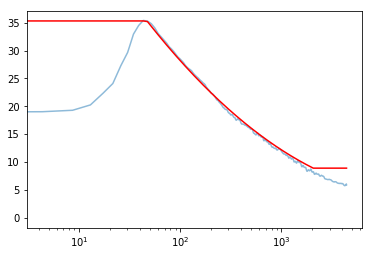

In [221]:
def new_spec(spectrum, averaging=3, alpha=0.5):
    slen = spectrum.shape[0]
    S = 20 * np.log10(spectrum[:slen//2])
    newS = np.zeros(S.shape)
    if averaging > 0:
        for i in range(1,S.shape[0]):
            width = round((np.log10(i * srate / slen))**averaging)
            width = 0 if width < 0 else int(width)
            left_end = i
            right_end = slen if i + width + 1 > slen else i + width + 1
            newS[i] = np.mean(S[left_end : right_end])

    #spectrum_plot(newS, proc_srate, show=False)        
    #Z = np.array([i for i in range(slen//2)])
    Z = np.linspace(0,srate/2,slen//2)
    plt.plot(Z, newS, alpha=alpha)
    #spectrum_plot(np.vectorize(freq_scale2)(Z), srate, show=False)
    plt.plot(Z, 35.3 + 20 * np.log10(np.vectorize(freq_scale2)(2*Z)), color='red')
    #plt.plot(Z, newS - 20 * np.log10(np.vectorize(freq_scale2)(Z)))

    #spectrum_plot(scipy.fft(0.01*testsin), srate, show=False)
    
    plt.xscale('log')
    plt.savefig("output/" + iden_str + "/" + "frequency_fit", dpi=300, transparent=True)
    plt.show()

new_spec(avg_fft)        

## Equalizing via FFT

In [ ]:
def equalized(X, fscale=freq_scale2):
    ftX = scipy.fft(X)
    for i, x in enumerate(ftX):
        ftX[i] = ftX[i] / fscale(i, slen=X.shape[0])
    return scipy.ifft(ftX).astype(np.float16)

def deequalized(X, fscale=freq_scale2):
    ftX = scipy.fft(X)
    for i, x in enumerate(ftX):
        ftX[i] = ftX[i] * fscale(i, slen=X.shape[0])
    return scipy.ifft(ftX).astype(np.float16)

In [251]:
win_size = slen
avg_fft = np.zeros(win_size, dtype=np.float64)
avg_equalized = np.zeros(win_size, dtype=np.float64)
num_ffts = 1000
for i in range(num_ffts):
    if i % 10 == 0:
        print(i, end=",")
    X = XX[np.random.randint(1,N)]
    new_fft = fft_avg(X, win_size=win_size)
    new_equalized = fft_avg(equalized(X, fscale=freq_scale2), win_size=win_size)
    #spectrum_plot(new_fft, proc_srate, show=False, averaging=2)
    #plt.plot(new_fft[:100])
    #plt.plot(new_equalized[:100])
    #spectrum_plot(new_equalized, proc_srate, show=False, averaging=2)
    #plt.show()
    #print(np.max(new_fft))
    avg_fft = avg_fft + new_fft
    avg_equalized = avg_equalized + new_equalized
avg_fft = avg_fft / num_ffts
avg_equalized = avg_equalized / num_ffts

0,

/home/umutisik/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,

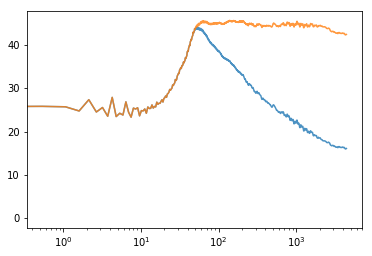

In [256]:
spectrum_plot(avg_fft, proc_srate, show=False, averaging=4)
spectrum_plot(avg_equalized, proc_srate, show=False, averaging=4)
plt.savefig("output/" + iden_str + "/" + "post-eq-frequencies", dpi=300, transparent=True)
plt.show()

## Equalizing the whole data-set


In [ ]:
proc_srate = 8820
h5f = h5py.File("../dataset/loops_" + str(proc_srate) + "hz.h5",'r')
XX = h5f['loops'][:]
mean_wave = h5f['mean'][:]
h5f.close()
N = XX.shape[0]
slen = XX.shape[1]

from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(8) 
#results = pool.map(my_function, my_array)

equa2 = lambda t: equalized(t, fscale=freq_scale2)
YY = pool.map(equa2, XX)

del XX
YY = np.array(YY, dtype=np.float16)
mean_wave = np.apply_along_axis(np.mean, 0, YY)
YY = YY - mean_wave

output_path = "../dataset/"
h5f = h5py.File(output_path + "8820_full_eqd_dataset.h5", "w")
h5f.create_dataset('loops', data=YY[:, ])
h5f.create_dataset('mean', data=mean_wave)
h5f.close()